In [1]:
%load_ext autoreload
%autoreload 2
#os.environ["OMP_NUM_THREADS"] = str(os.cpu_count() // 2)
#os.environ["GOMP_CPU_AFFINITY"] = "granularity=core,compact"
from Scripts.model import *
from Scripts.asymmetric_model import *
from Scripts.loss import *
from Scripts.results_manager import *
from Scripts.plots import *
from Scripts.dataset import *
from Scripts.trainer import *
from Scripts.inference import *
from Scripts.Onnx_Class import *
from Scripts.lr_finder import *
from Scripts.generate_configs import *
#from Scripts.asymmetric_model import *
from Scripts.generate_asymmetric_configs import *
from Scripts.excecute import *
from Scripts.quantize_new import *
from Scripts.upload_summaries import *

c:\Users\alant\AppData\Local\Programs\Python\Python313\Lib\site-packages\openvino\runtime\__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(


In [ ]:
config_path = "Asymmetric_Configs"

In [ ]:
training_selected_class(config_path, 'grid')
# metrics_to_db()

In [ ]:
training_all_classes(config_path)
metrics_to_db()

In [ ]:
training_run_folder = "Training_Runs"
inference_output_dir = "Inference_Runs"

inference_model(training_run_folder, inference_output_dir)

In [ ]:
# --- Unveränderter Teil: Pfade sammeln ---
config_paths_all = glob.glob(os.path.join(
    "Training_Runs", "**", "*.yaml"), recursive=True)
summary_metrics_paths_all = glob.glob(os.path.join(
    "Training_Runs", "**", "summary_metrics.json"), recursive=True)
best_student_weight_paths_all = glob.glob(os.path.join(
    "Training_Runs", "**", "*best_student.pth"), recursive=True)

config_paths = [
    p for p in config_paths_all if not any(part.startswith('tf_efficient') for part in p.split(os.sep))]
summary_metrics_paths = [
    p for p in summary_metrics_paths_all if not any(part.startswith('tf_efficient') for part in p.split(os.sep))]
best_student_weight_paths = [
    p for p in best_student_weight_paths_all if not any(part.startswith('tf_efficient') for part in p.split(os.sep))]


for configs, summary_metrics, best_student_weights in zip(config_paths, summary_metrics_paths, best_student_weight_paths):
    config = load_config(configs)
    summary_metric = load_json(summary_metrics)
    quantize_model(
        best_student_weights,
        config,
        summary_metric
    )

In [ ]:
inference_output_dir = 'quantized_inference_results'
cpu_device = torch.device("cpu")

# Finde alle quantisierten Modelle im Ordner
quantized_weight_paths = glob.glob(os.path.join(
    "quantized_models", "**", "quantized_model.pth"), recursive=True)

print(
    f"Führe Inferenz für {len(quantized_weight_paths)} quantisierte Modelle aus...")

for weight_path in quantized_weight_paths:
    dirpath = os.path.dirname(weight_path)
    print(f"\n--- Verarbeite Modell in: {dirpath} ---")

    # Finde die zugehörigen Konfigurationsdateien
    yaml_filename = None
    for file in os.listdir(dirpath):
        if file.endswith('.yaml'):
            yaml_filename = file
            break

    if yaml_filename is None:
        print(
            f"Warnung: Keine YAML-Konfigurationsdatei in {dirpath} gefunden. Überspringe.")
        continue

    json_path = os.path.join(dirpath, "summary_metric.json")
    yaml_path = os.path.join(dirpath, yaml_filename)

    if not os.path.exists(json_path):
        print(
            f"Warnung: Keine summary_metric.json in {dirpath} gefunden. Überspringe.")
        continue

    # Lade Konfigurationen
    config_data = load_config(yaml_path)
    summary_data = load_json(json_path)
    training_id = summary_data.get(
        'training_id', 'quantized_run')  # Nutze Fallback

    # --- WICHTIGER TEIL: Lade das quantisierte Modell korrekt ---

    # 1. Erstelle das leere STFPM-Modellgerüst
    inference_model = STFPM(
        architecture=config_data['model']['architecture'],
        layers=config_data['model']['layers']
    )
    inference_model.eval()
    student_model_to_quantize = inference_model.student_model
    student_model_to_quantize.eval()

    # 2. Bereite das student_model mit der exakt gleichen FX-Konfiguration vor
    qconfig_mapping = get_default_qconfig_mapping("fbgemm")
    example_inputs = (torch.randn(1, 3, 256, 256),)
    prepared_model = prepare_fx(
        student_model_to_quantize, qconfig_mapping, example_inputs)
    quantized_student_model = convert_fx(prepared_model)

    # 3. Lade jetzt die gespeicherten, quantisierten Gewichte
    quantized_student_model.load_state_dict(
        torch.load(weight_path, map_location=cpu_device))
    quantized_student_model.eval()
    print("Quantisierte Gewichte erfolgreich geladen.")

    # 4. Setze das quantisierte student_model in das STFPM-Gesamtmodell ein
    inference_model.student_model = quantized_student_model
    inference_model.to(cpu_device)

    # --- Ab hier läuft die Inferenz wie gewohnt ---

    # Lade die Testdaten
    try:
        test_set = MVTecDataset(
            img_size=config_data['dataset']['img_size'],
            base_path=config_data['dataset']['base_path'],
            cls=config_data['dataset']['class'],
            mode='test',
            download_if_missing=False
        )
        test_loader = DataLoader(
            test_set,
            batch_size=config_data['dataloader']['batch_size'],
            shuffle=False
        )
    except Exception as e:
        print(f"Fehler beim Laden des Test-Datensatzes für {yaml_path}: {e}")
        continue

    # Führe die Inferenz aus
    infer = Inference(
        model=inference_model,
        test_loader=test_loader,
        config=config_data,
        output_dir=inference_output_dir,
        path_to_student_weight=None,
        trainings_id=training_id,
        inferenz=True
    )

    print(f"Starte Inferenz für Konfiguration: {yaml_path}...")
    auroc_score, total_inference_time = infer.evaluate_loaded_model()
    infer.create_inference_summary(
        summary_data, auroc_score, total_inference_time)
    print(
        f"Inferenz abgeschlossen. AUROC: {auroc_score:.4f}, Zeit: {total_inference_time:.4f}s.")

    infer.generate_heatmaps_from_saved_maps()

print("\n--- Alle Inferenzläufe abgeschlossen. ---")

Anomalie-Score für das Bild: 0.0005228028749115765


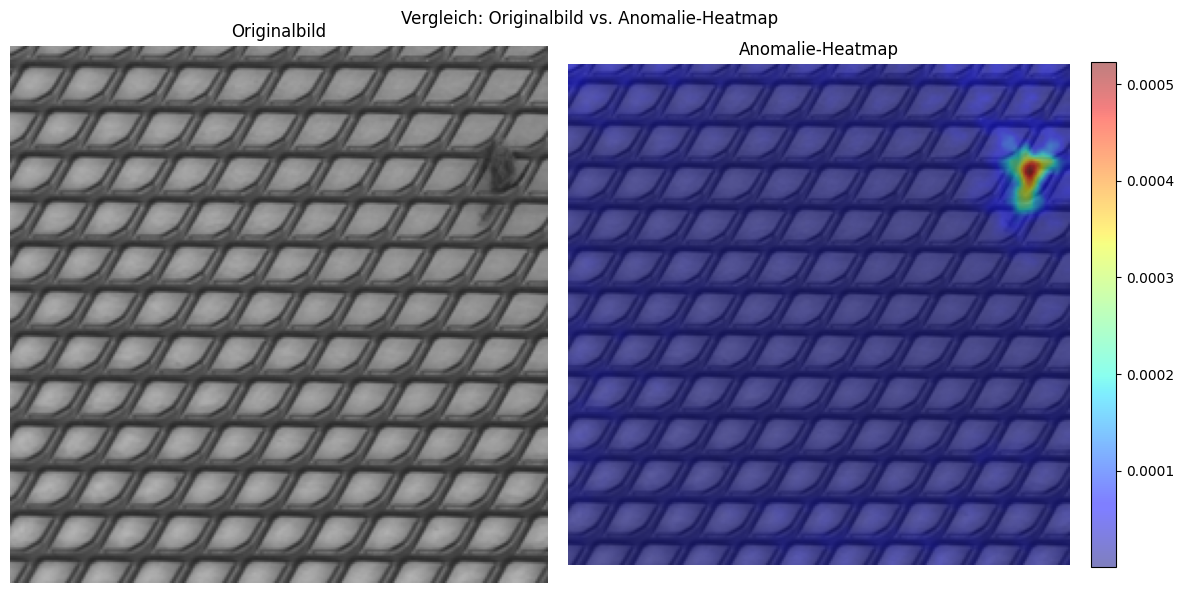

Anomalie-Score für das Bild: 0.0006889778305776417


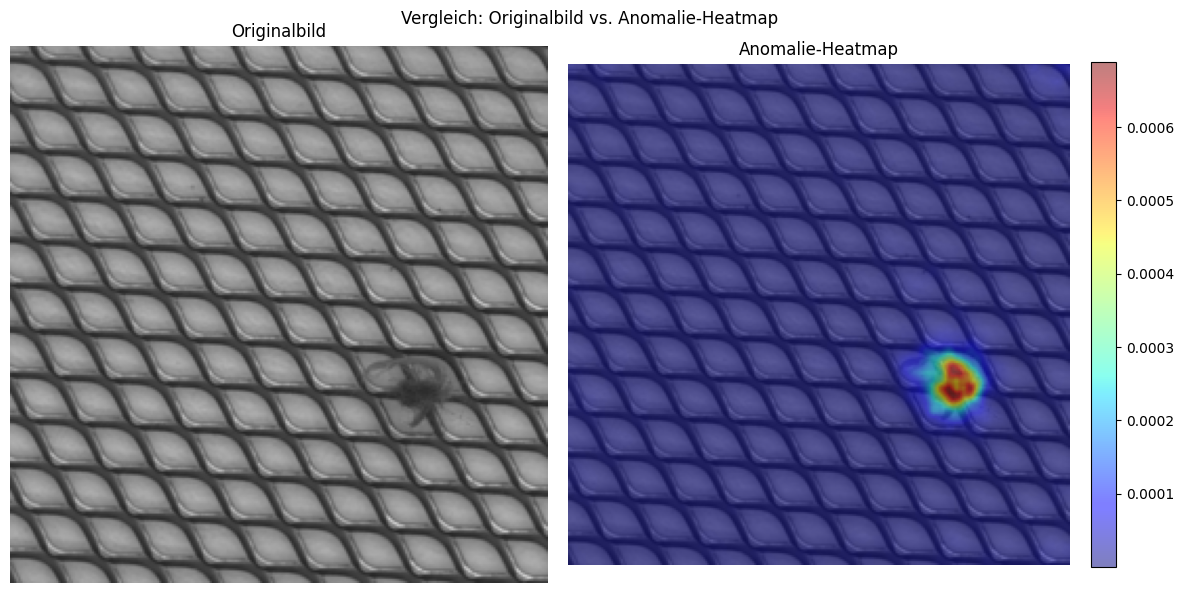

Anomalie-Score für das Bild: 8.100807463051751e-05


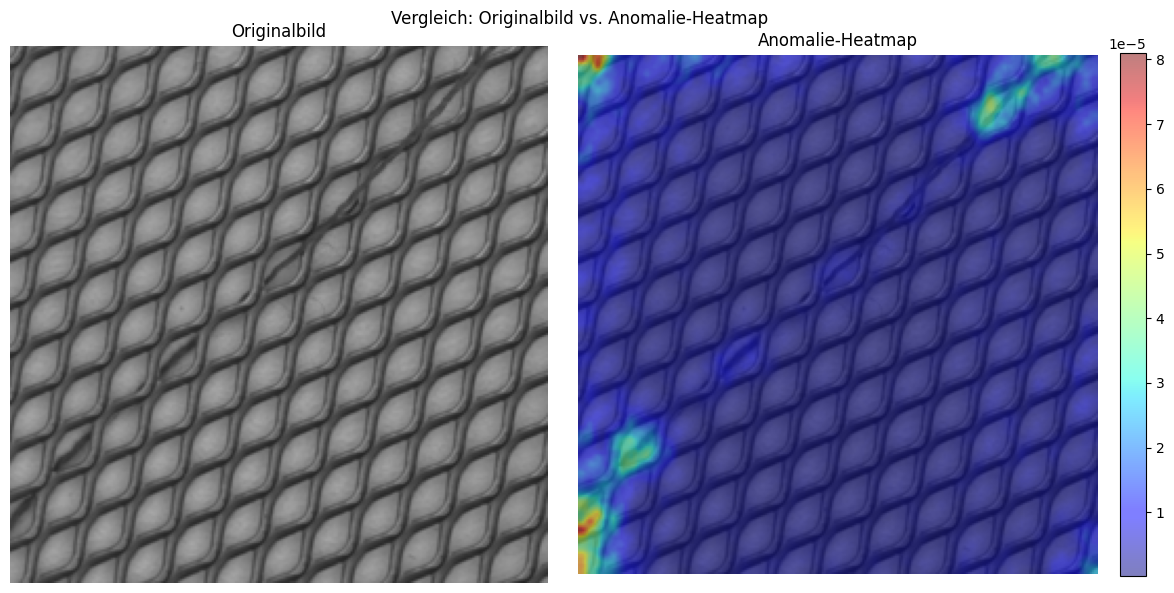

Anomalie-Score für das Bild: 9.260987280867994e-05


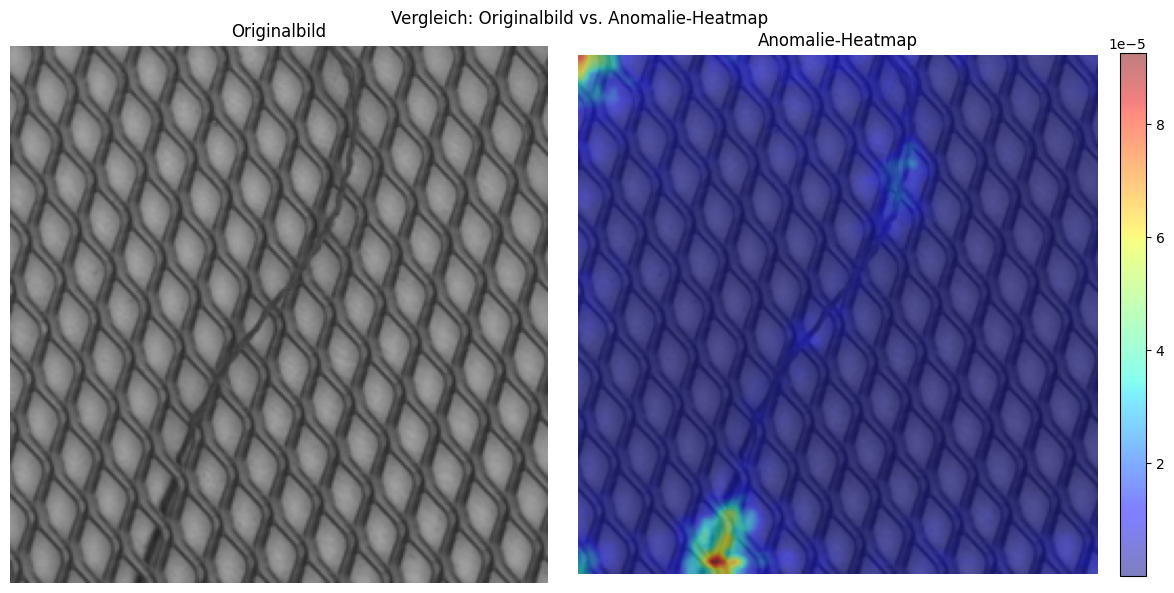

Anomalie-Score für das Bild: 0.0005314266309142113


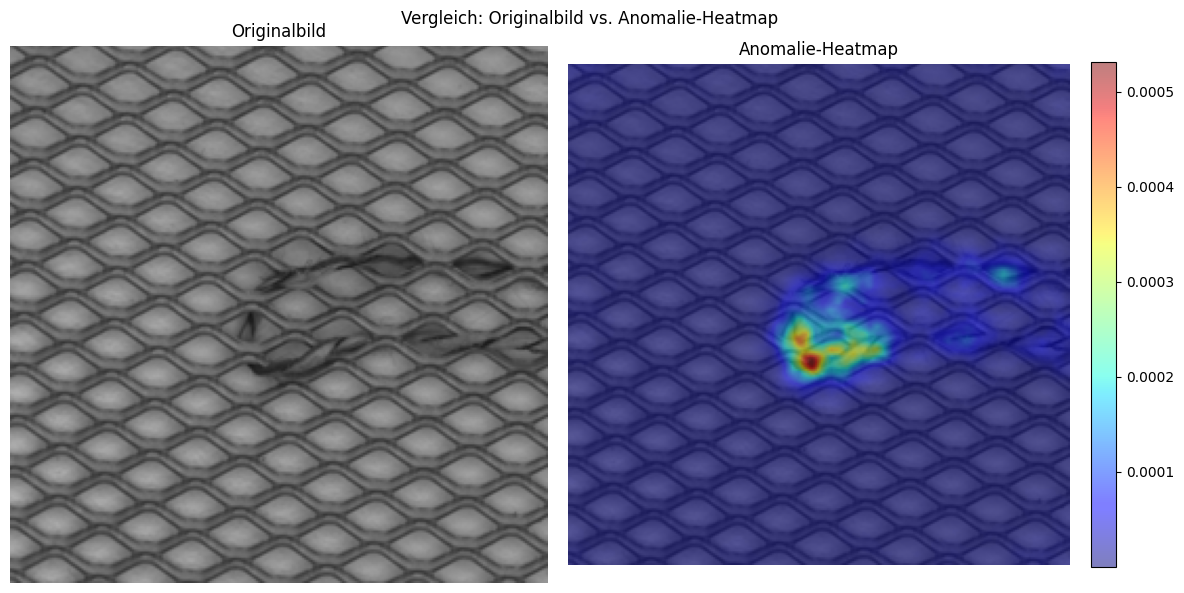

Anomalie-Score für das Bild: 0.004618110600858927


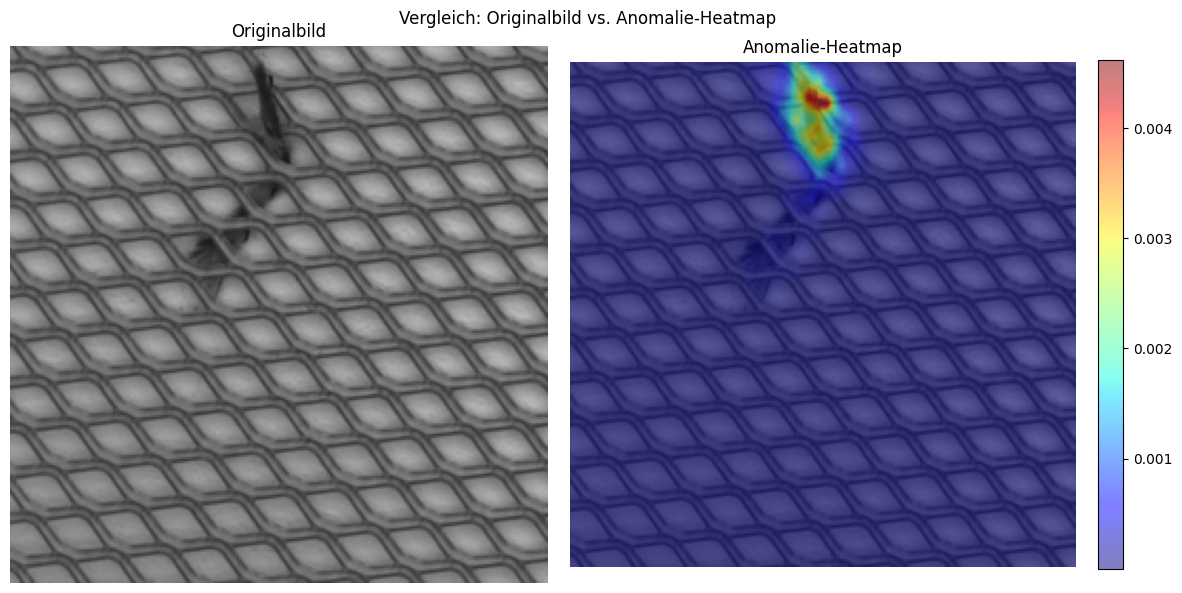

Anomalie-Score für das Bild: 0.0004373093252070248


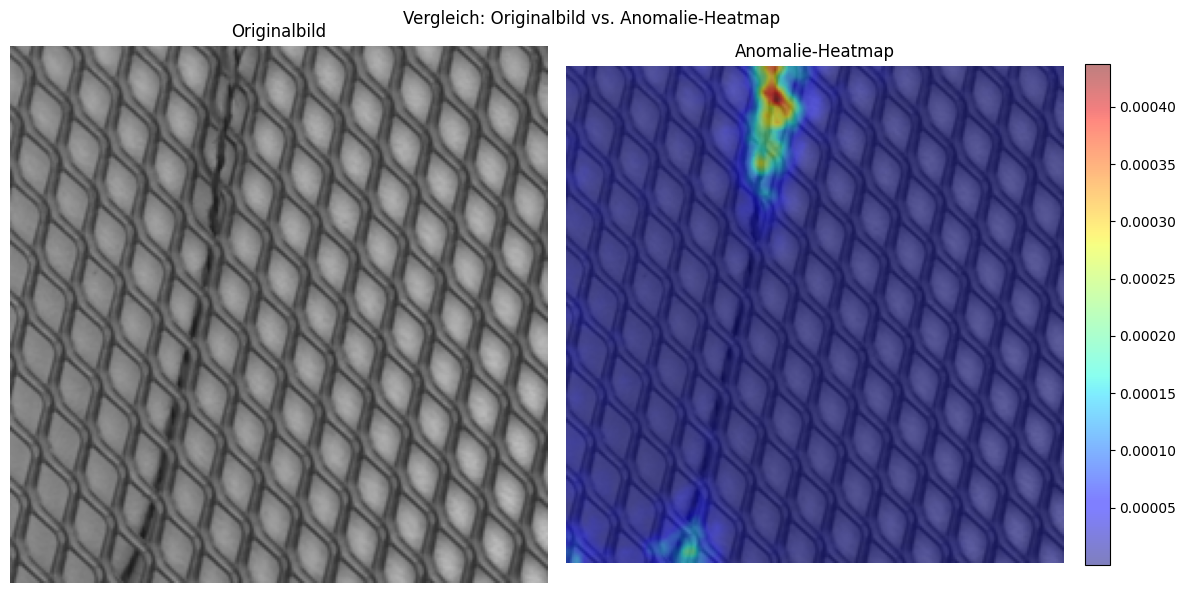

Anomalie-Score für das Bild: 0.00010296305117662996


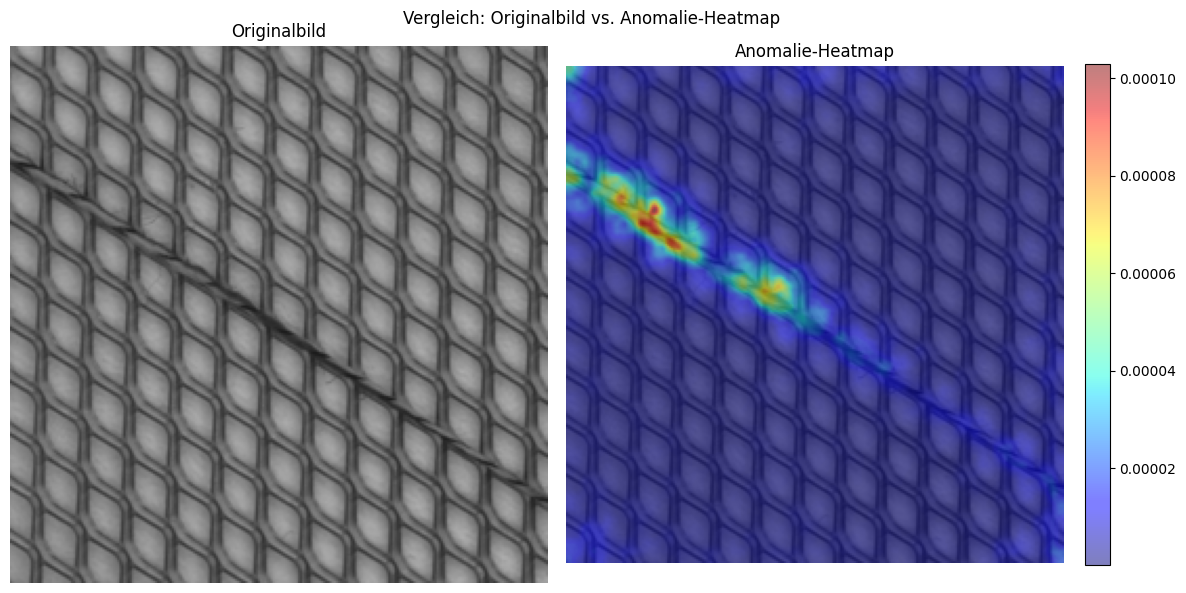

Anomalie-Score für das Bild: 0.00024094822583720088


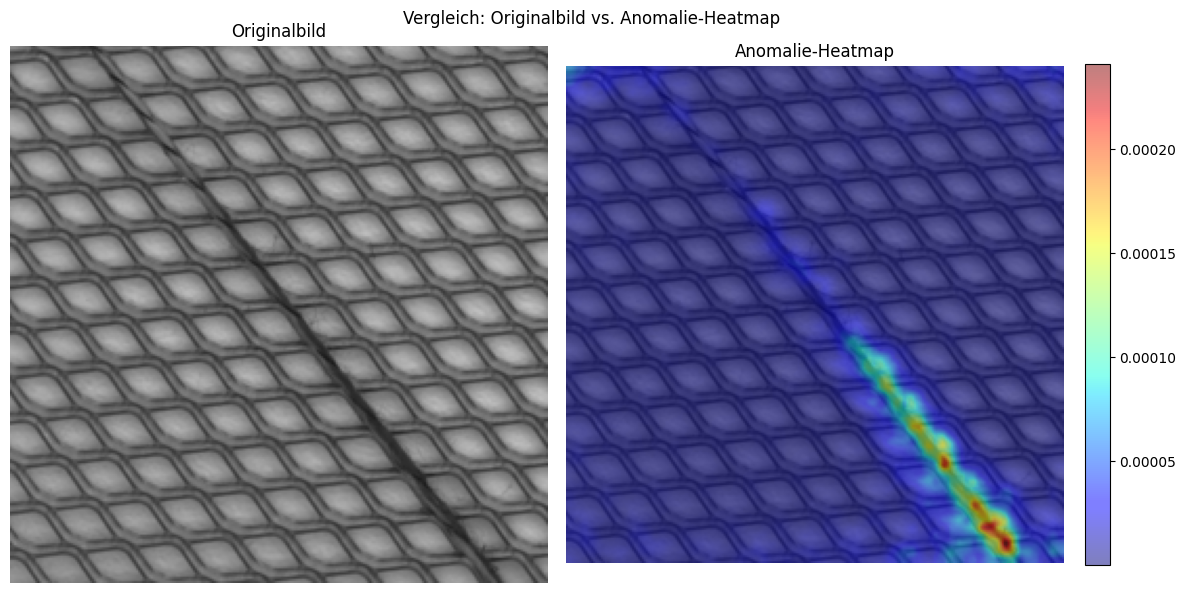

Anomalie-Score für das Bild: 0.0002526434836909175


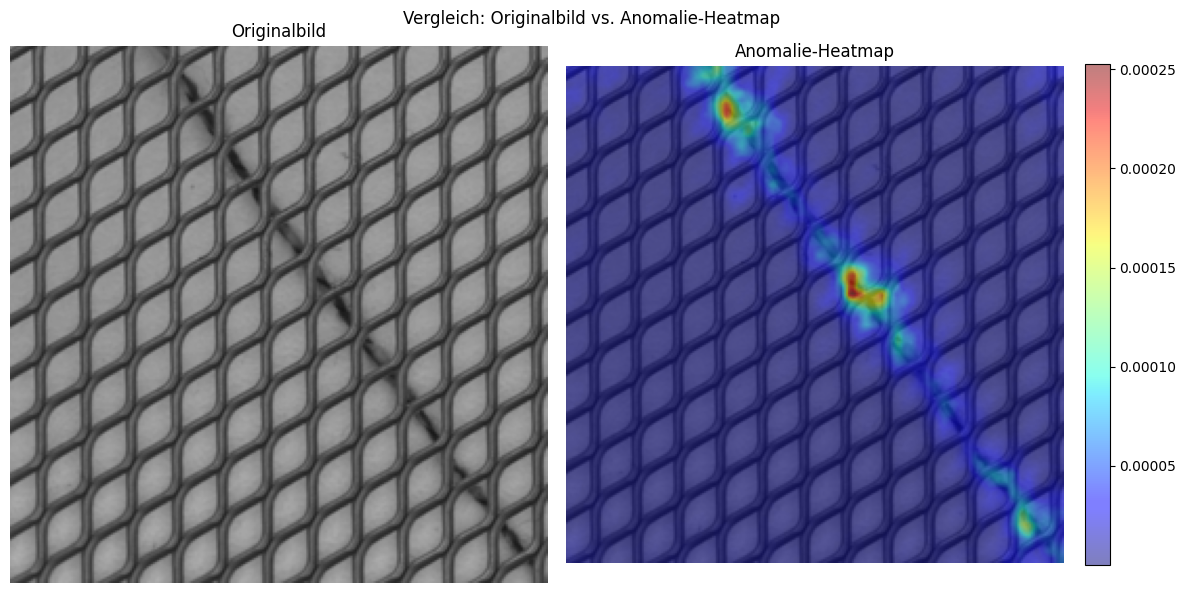

Anomalie-Score für das Bild: 0.0009315037168562412


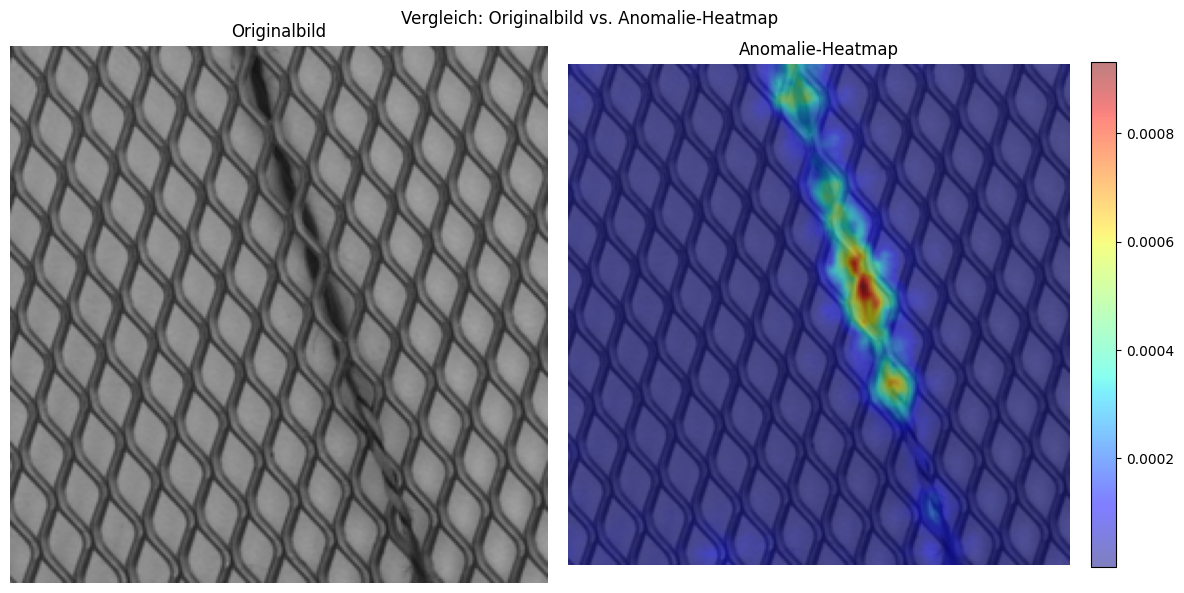

In [2]:
import onnxruntime as ort
import numpy as np
from PIL import Image

# 1. ONNX-Modell laden
onnx_model_path = r"onnx_models\STFPM_resnet18.onnx"
sess = ort.InferenceSession(onnx_model_path)

image_path = glob.glob(os.path.join(
    r'Images\grid\test\thread', '*.png'))
for path in image_path:

    # 2. Ein Bild für die Inferenz vorbereiten
    # image_path = r"Images\grid\test\bent\003.png"
    image = Image.open(path).convert("RGB")

    # Resize the image to the expected input size
    img_size = 256
    image = image.resize((img_size, img_size))

    input_data = np.array(image, dtype=np.uint8)
    input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension

    # 3. Inferenz durchführen
    input_name = sess.get_inputs()[0].name
    outputs = sess.run(None, {input_name: input_data})

    # 4. Ergebnisse auswerten
    anomaly_map = outputs[0]
    anomaly_score = outputs[1]

    print(f"Anomalie-Score für das Bild: {anomaly_score[0]}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # 2. Originalbild anzeigen
    axes[0].imshow(image)
    axes[0].set_title("Originalbild")
    axes[0].axis('off')

    # 3. Heatmap über das Originalbild legen
    axes[1].imshow(image)
    heatmap = axes[1].imshow(np.squeeze(anomaly_map), cmap='jet', alpha=0.5)
    axes[1].set_title("Anomalie-Heatmap")
    axes[1].axis('off')

    # 4. Farbbalken für die Heatmap hinzufügen
    fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # 5. Plot anzeigen oder speichern
    plt.suptitle("Vergleich: Originalbild vs. Anomalie-Heatmap")
    plt.show()